 # ****Google Analytics Customer Revenue Prediction****

### The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

This notebook is analysis for a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.

For each fullVisitorId in the test set, predict the natural log of their total revenue in PredictedLogRevenue, noting that one customer may have number of transactions in data.
 
####  IMPORTANT: Due to the formatting of fullVisitorId you must load the Id's as strings in order for all Id's to be properly unique!

#### There are multiple columns which contain JSON blobs of varying depth



## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gc
import sys
import math

from pandas.io.json import json_normalize
from datetime import datetime

import os
print(os.listdir("../input/ga-customer-revenue-prediction"))

['sample_submission.csv', 'train_v2.csv', 'test_v2.csv', 'sample_submission_v2.csv', 'train.csv', 'test.csv']


 As data exceeds million records that we may go through memory problems, Notice that data contains number of non important features due to their null values that exceed 90%, so I didn't load them from the beginning and only selected and loaded the valid features.

In [2]:
#function to load load data and normalize the json data columns

gc.enable()
  
features = ['channelGrouping', 'date', 'fullVisitorId','socialEngagementType', 'visitId',\
       'visitNumber', 'visitStartTime', 'device.browser',\
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', \
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',\
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',\
       'geoNetwork.subContinent', 'totals.visits', 'totals.hits',\
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue','totals.totalTransactionRevenue',\
       'trafficSource.adContent', 'trafficSource.campaign', 'trafficSource.medium', \
       'trafficSource.source', 'customDimensions']

  
        
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    ans = pd.DataFrame()
    dfs = pd.read_csv(csv_path, sep=',',
            converters={column: json.loads for column in JSON_COLUMNS}, 
            dtype={'fullVisitorId': 'str'}, 
            chunksize=100000)
    
    for df in dfs:
        df.reset_index(drop=True, inplace=True)
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

       
        use_df = df[features]
        del df
        gc.collect()
        ans = pd.concat([ans, use_df], axis=0).reset_index(drop=True)
   
    return ans

In [3]:
#load data and checking time interval of both train and test

df_train = load_df('../input/ga-customer-revenue-prediction/train_v2.csv')
df_test = load_df('../input/ga-customer-revenue-prediction/test_v2.csv')

print('train date:', min(df_train['date']), 'to', max(df_train['date']))
print('test date:', min(df_test['date']), 'to', max(df_test['date']))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


train date: 20160801 to 20180430
test date: 20180501 to 20181015


In [4]:
#reduce memory usage by adjust the reserved size of datatypes as per need. 

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data types to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Initial Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Initial Memory usage of dataframe is 384375953.00 MB
Memory usage after optimization is: 355334224.00 MB
Decreased by 7.6%
Initial Memory usage of dataframe is 90357653.00 MB
Memory usage after optimization is: 83530640.00 MB
Decreased by 7.6%


## Exploratory Data Analysis

In [5]:
print(df_train.shape)
print(df_test.shape)

(1708337, 29)
(401589, 29)


In [6]:
df_train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'socialEngagementType',
       'visitId', 'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.visits', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'totals.totalTransactionRevenue', 'trafficSource.adContent',
       'trafficSource.campaign', 'trafficSource.medium',
       'trafficSource.source', 'customDimensions'],
      dtype='object')

In [7]:
df_train.dtypes

channelGrouping                    object
date                                int32
fullVisitorId                      object
socialEngagementType               object
visitId                             int32
visitNumber                         int16
visitStartTime                      int32
device.browser                     object
device.deviceCategory              object
device.isMobile                   float16
device.operatingSystem             object
geoNetwork.city                    object
geoNetwork.continent               object
geoNetwork.country                 object
geoNetwork.metro                   object
geoNetwork.networkDomain           object
geoNetwork.region                  object
geoNetwork.subContinent            object
totals.visits                      object
totals.hits                        object
totals.newVisits                   object
totals.pageviews                   object
totals.transactionRevenue          object
totals.totalTransactionRevenue    

In [8]:
df_train.select_dtypes(include='object').columns

Index(['channelGrouping', 'fullVisitorId', 'socialEngagementType',
       'device.browser', 'device.deviceCategory', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.visits', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'totals.totalTransactionRevenue', 'trafficSource.adContent',
       'trafficSource.campaign', 'trafficSource.medium',
       'trafficSource.source', 'customDimensions'],
      dtype='object')

In [9]:
df_train.select_dtypes(exclude='object').columns

Index(['date', 'visitId', 'visitNumber', 'visitStartTime', 'device.isMobile'], dtype='object')

In [10]:
df_train.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.medium,trafficSource.source,customDimensions
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,desktop,0.0,...,1,1,1,NaN,NaN,NaN,(not set),organic,google,"[{'index': '4', 'value': 'EMEA'}]"
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,desktop,0.0,...,2,NaN,2,NaN,NaN,NaN,(not set),referral,sites.google.com,"[{'index': '4', 'value': 'North America'}]"
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,mobile,1.0,...,2,1,2,NaN,NaN,NaN,(not set),(none),(direct),"[{'index': '4', 'value': 'North America'}]"
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,desktop,0.0,...,2,1,2,NaN,NaN,NaN,(not set),organic,google,"[{'index': '4', 'value': 'EMEA'}]"
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,desktop,0.0,...,2,1,2,NaN,NaN,NaN,(not set),organic,google,"[{'index': '4', 'value': 'Central America'}]"


## Checking and Filling Nulls

In [11]:
#check columns contain nulls with their null percentage
null_percentage = pd.DataFrame()
for col in df_train.columns:
    if df_train[col].isnull().sum() > 0:
        null_percentage.loc[col,'NullPercentage'] = (df_train[col].isnull().sum())/len(df_train) * 100 
print(null_percentage)
        

                                NullPercentage
totals.newVisits                     23.467676
totals.pageviews                      0.013990
totals.transactionRevenue            98.916256
totals.totalTransactionRevenue       98.916256
trafficSource.adContent              96.210525


#### Note that the 98.9% null percentage in our target column 'totals.transactionRevenue' is not a problem, as null means zero revenue for this transaction, which proves what is documented in the competition overview "only 20% only from customers making the revenue"

'totals.totalTransactionRevenue' is a duplicated column, so I'll drop it.

'trafficSource.adContent' contains to much null so I'll drop it as well.

'totals.newVisits' & 'totals.pageviews' could be imputed.

In [12]:
df_train['totals.transactionRevenue'].value_counts()

16990000     308
19990000     248
39980000     220
18990000     219
21990000     211
            ... 
319300000      1
120310000      1
19690000       1
344280000      1
69390000       1
Name: totals.transactionRevenue, Length: 7251, dtype: int64

In [13]:
#As this is a duplicate column
df_train.drop('totals.totalTransactionRevenue', axis=1, inplace=True)
df_test.drop('totals.totalTransactionRevenue', axis=1, inplace=True)

In [14]:
df_train.drop('trafficSource.adContent', axis=1, inplace=True)

In [15]:
#fill null in 'totals.pageviews' by mode
print(df_train['totals.pageviews'].isnull().sum())
print(df_train['totals.pageviews'].dtype)

print(df_train['totals.pageviews'] .mode())
print((df_train["totals.pageviews"]=='1').sum())
df_train['totals.pageviews'] = df_train['totals.pageviews'].fillna(1)

df_train['totals.pageviews'] = df_train['totals.pageviews'].astype(int)

239
object
0    1
dtype: object
876328


In [16]:
#fill null in 'totals.newVisits' by mode
print(df_train['totals.newVisits'].isnull().sum())
print(df_train['totals.newVisits'].dtype)

print(df_train['totals.newVisits'] .mode())
print((df_train["totals.newVisits"]=='1').sum())
df_train['totals.pageviews'] = df_train['totals.pageviews'].fillna(1)

df_train['totals.pageviews'] = df_train['totals.pageviews'].astype(int)

400907
object
0    1
dtype: object
1307430


##### Check number of customers in train dataset from whole visits/transactions number

In [17]:
unique_customers_no = df_train['fullVisitorId'].nunique()
total_customers_no = df_train['visitId'].count()
print("No of unique customers {} from {} total customers".format(unique_customers_no , total_customers_no))

No of unique customers 1323730 from 1708337 total customers


##### Check least and highest transaction revenue

In [18]:
df_train['totals.transactionRevenue'] = df_train['totals.transactionRevenue'].astype(float)
df_train['totals.transactionRevenue'] = df_train['totals.transactionRevenue'].fillna(0)

print(df_train['totals.transactionRevenue'].sort_values().unique()[1])
print(df_train['totals.transactionRevenue'].sort_values().unique()[-1])


10000.0
23129500000.0


##### Check number and percentage of customers that make revenue

In [19]:
target = df_train.groupby('fullVisitorId')[['totals.transactionRevenue']].sum().reset_index()

customers_making_revenue = (target["totals.transactionRevenue"]>0).sum()

print("No of different customers with no zero revenue= {} from total {} customers".format(customers_making_revenue,unique_customers_no))
print("Percentage of customers with no zero revenue = ",round(customers_making_revenue/unique_customers_no*100 , 2))    


No of different customers with no zero revenue= 16141 from total 1323730 customers
Percentage of customers with no zero revenue =  1.22


##### Check top 5 customers as per monetary (asses in revenue)

In [20]:
target.sort_values(by='totals.transactionRevenue' , ascending=False).head()

,fullVisitorId,totals.transactionRevenue
258942,1957458976293878100,1.198516e+11
745015,5632276788326171571,1.602375e+10
1246696,9417857471295131045,1.517012e+10
591522,4471415710206918415,1.121110e+10
659421,4984366501121503466,9.513900e+09


Text(0, 0.5, 'Number of Customers')

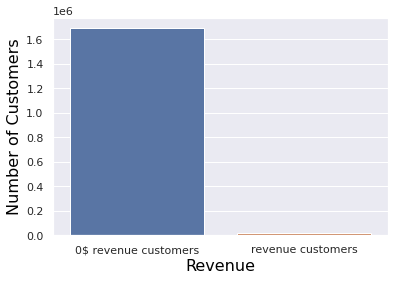

In [21]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x=pd.cut( df_train['totals.transactionRevenue'], [-10,0,2e11]) )
ax.set_xticklabels(["0$ revenue customers" , "revenue customers"])
ax.set_xlabel('Revenue' , fontsize=16 , color='Black')
ax.set_ylabel('Number of Customers' , fontsize=16 , color='Black')

In [22]:
df_train2 = df_train.copy()

#### Visualize to check effect of some features on: transaction number,  transaction with revenue number, average revenue

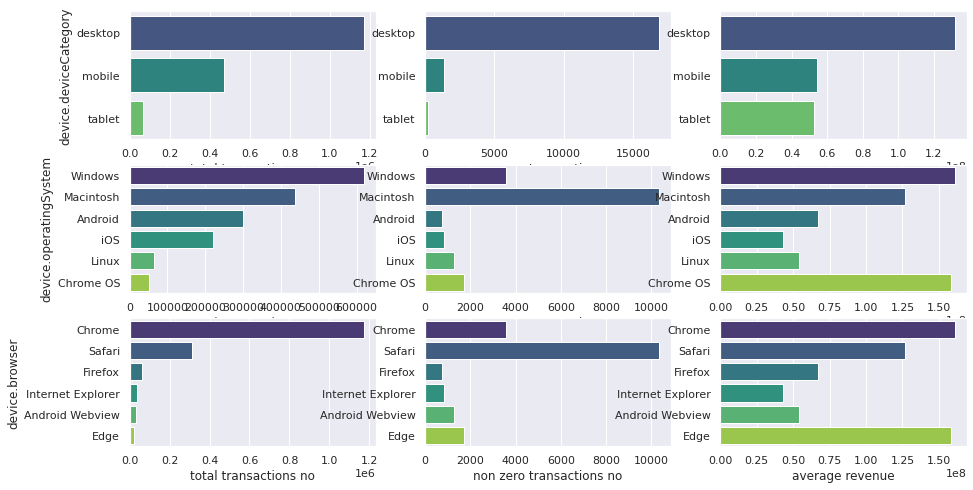

In [23]:
df_train2['totals.transactionRevenue'] = df_train2['totals.transactionRevenue'].replace(0,np.nan)


dev_category = df_train2.groupby('device.deviceCategory')[['totals.transactionRevenue']].agg(['size', 'count', 'mean'])
dev_category.columns = ['total transactions no','non zero transactions no','average revenue']

dev_os = df_train2.groupby('device.operatingSystem')[['totals.transactionRevenue']].agg(['size', 'count', 'mean'])
dev_os.columns = ['total transactions no','non zero transactions no','average revenue']
dev_os = dev_os.sort_values(by='total transactions no', ascending=False)

dev_browser = df_train2.groupby('device.browser')[['totals.transactionRevenue']].agg(['size', 'count', 'mean'])
dev_browser.columns = ['total transactions no','non zero transactions no','average revenue']
dev_browser = dev_browser.sort_values(by='total transactions no', ascending=False)


#plt.figure(figsize=(12,4))
fig , ax = plt.subplots(3 , 3 , figsize=(15,8))
plt.subplot(3,3,1)
sns.barplot(y=dev_category.index , x=dev_category['total transactions no'],palette="viridis")
plt.subplot(3,3,2)
sns.barplot(y=dev_category.index , x=dev_category['non zero transactions no'],palette="viridis").set(ylabel=None)
plt.subplot(3,3,3)
sns.barplot(y=dev_category.index , x=dev_category['average revenue'],palette="viridis").set(ylabel=None)

plt.subplot(3,3,4)
sns.barplot(y=dev_os.index[0:6] , x=dev_os['total transactions no'].head(6) ,palette="viridis")
plt.subplot(3,3,5)
sns.barplot(data=dev_os.head(5), y=dev_os.index[0:6], x=dev_os['non zero transactions no'].head(6), palette="viridis").set(ylabel=None)
plt.subplot(3,3,6)
sns.barplot(data=dev_os.head(5), y=dev_os.index[0:6] , x=dev_os['average revenue'].head(6), palette="viridis").set(ylabel=None)

plt.subplot(3,3,7)
sns.barplot(y=dev_browser.index[0:6] , x=dev_browser['total transactions no'].head(6) ,palette="viridis")
plt.subplot(3,3,8)
sns.barplot(y=dev_browser.index[0:6], x=dev_os['non zero transactions no'].head(6), palette="viridis").set(ylabel=None)
plt.subplot(3,3,9)
sns.barplot(y=dev_browser.index[0:6] , x=dev_os['average revenue'].head(6), palette="viridis").set(ylabel=None)

fig.show()

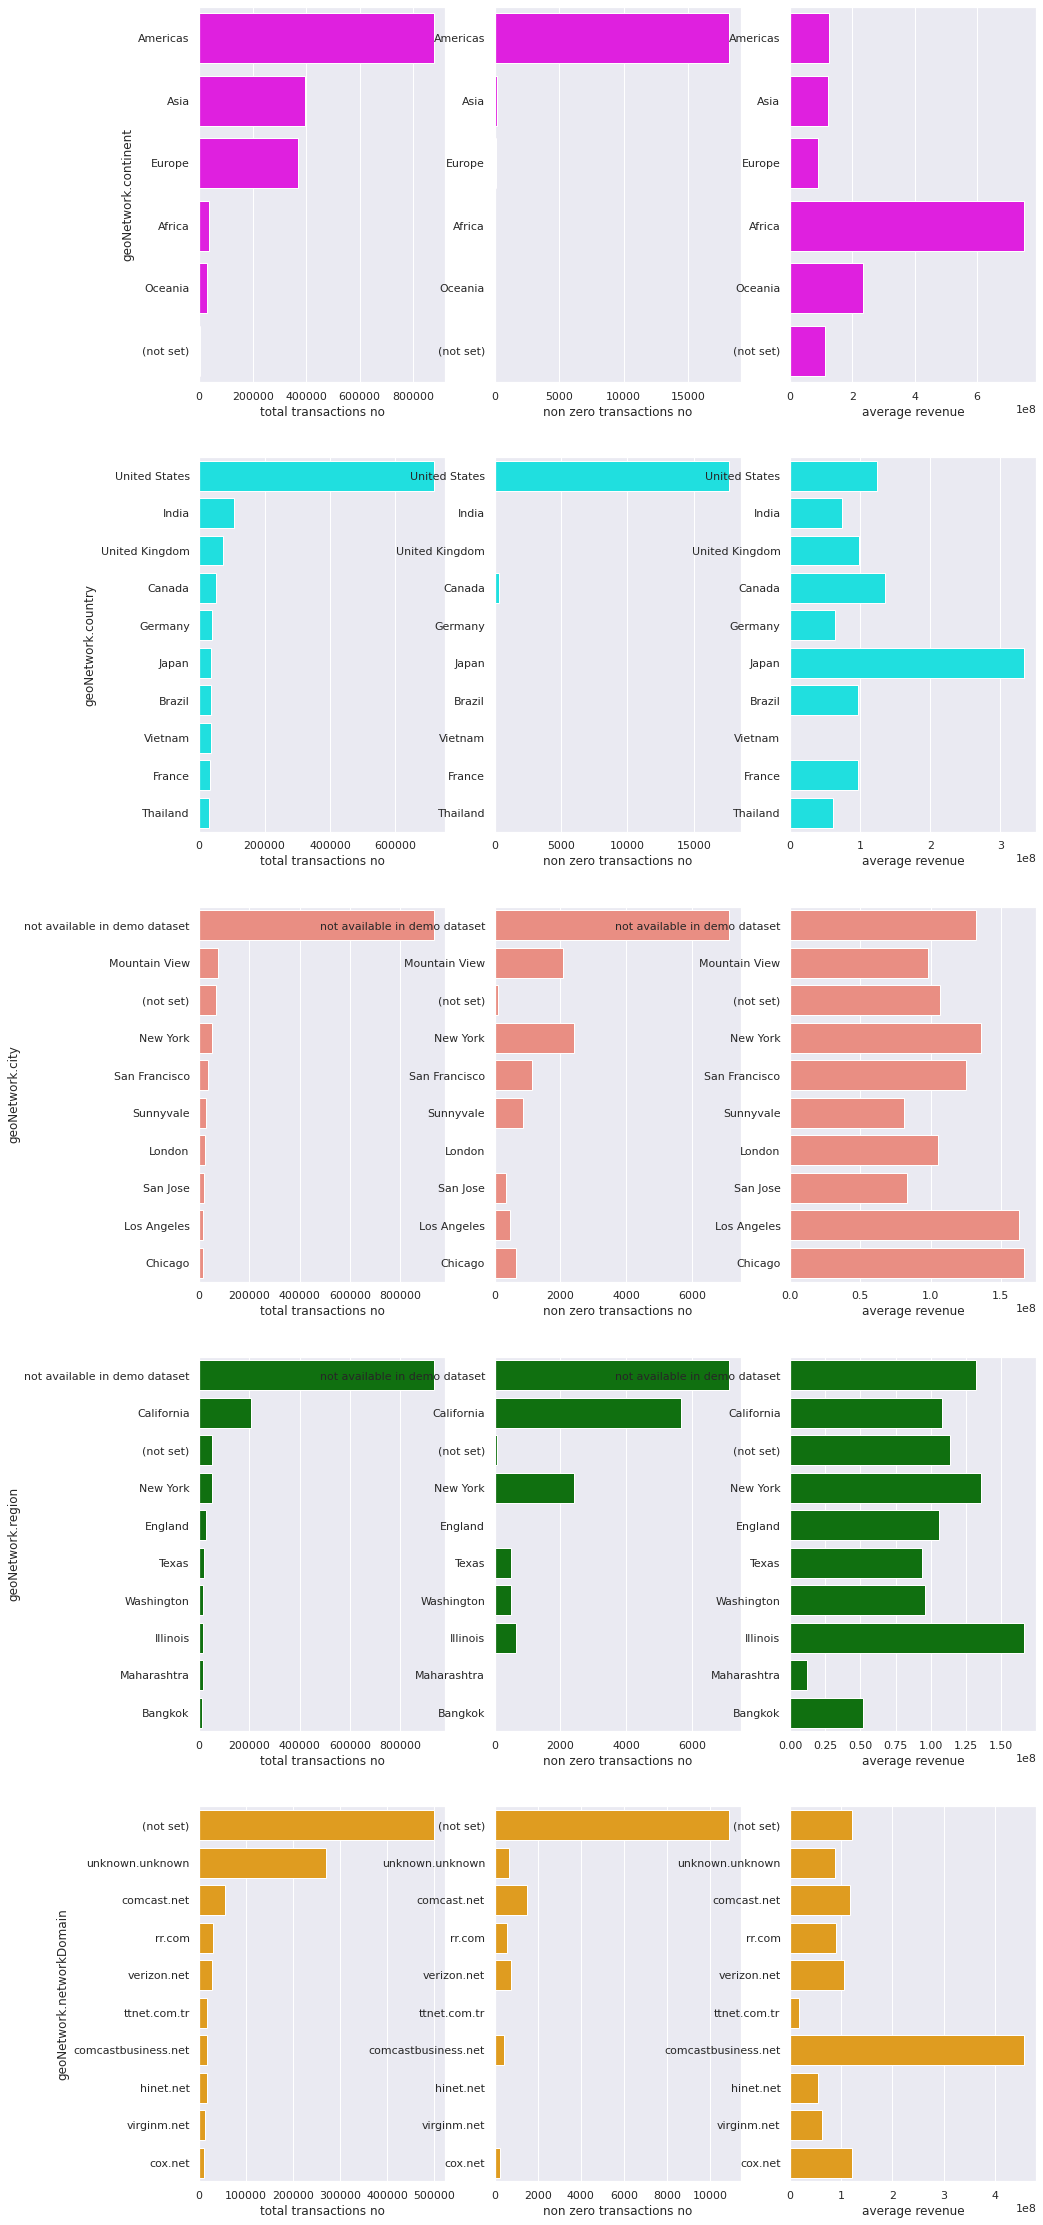

In [24]:
geo_continent = df_train2.groupby('geoNetwork.continent')[['totals.transactionRevenue']].agg(['size', 'count', 'mean'])
geo_continent.columns = ['total transactions no','non zero transactions no','average revenue']
geo_continent = geo_continent.sort_values(by='total transactions no', ascending=False)

geo_country = df_train2.groupby('geoNetwork.country')[['totals.transactionRevenue']].agg(['size', 'count', 'mean'])
geo_country.columns = ['total transactions no','non zero transactions no','average revenue']
geo_country = geo_country.sort_values(by='total transactions no', ascending=False)

geo_city = df_train2.groupby('geoNetwork.city')[['totals.transactionRevenue']].agg(['size', 'count', 'mean'])
geo_city.columns = ['total transactions no','non zero transactions no','average revenue']
geo_city = geo_city.sort_values(by='total transactions no', ascending=False)

geo_region = df_train2.groupby('geoNetwork.region')[['totals.transactionRevenue']].agg(['size', 'count', 'mean'])
geo_region.columns = ['total transactions no','non zero transactions no','average revenue']
geo_region = geo_region.sort_values(by='total transactions no', ascending=False)

geo_network = df_train2.groupby('geoNetwork.networkDomain')[['totals.transactionRevenue']].agg(['size', 'count', 'mean'])
geo_network.columns = ['total transactions no','non zero transactions no','average revenue']
geo_network = geo_network.sort_values(by='total transactions no', ascending=False)


#plt.figure(figsize=(12,4))
fig , ax = plt.subplots(5 , 3 , figsize=(15,40))
plt.subplot(5,3,1)
sns.barplot(y=geo_continent.index , x=geo_continent['total transactions no'],color="magenta")
plt.subplot(5,3,2)
sns.barplot(y=geo_continent.index , x=geo_continent['non zero transactions no'],color="magenta").set(ylabel=None)
plt.subplot(5,3,3)
sns.barplot(y=geo_continent.index , x=geo_continent['average revenue'],color="magenta").set(ylabel=None)

plt.subplot(5,3,4)
sns.barplot(y=geo_country.index[0:10] , x=geo_country['total transactions no'].head(10) ,color="cyan")
plt.subplot(5,3,5)
sns.barplot(y=geo_country.index[0:10], x=geo_country['non zero transactions no'].head(10), color="cyan").set(ylabel=None)
plt.subplot(5,3,6)
sns.barplot(y=geo_country.index[0:10] , x=geo_country['average revenue'].head(10), color="cyan").set(ylabel=None)

plt.subplot(5,3,7)
sns.barplot(y=geo_city.index[0:10] , x=geo_city['total transactions no'].head(10) ,color="salmon")
plt.subplot(5,3,8)
sns.barplot(y=geo_city.index[0:10], x=geo_city['non zero transactions no'].head(10), color="salmon").set(ylabel=None)
plt.subplot(5,3,9)
sns.barplot(y=geo_city.index[0:10] , x=geo_city['average revenue'].head(10), color="salmon").set(ylabel=None)

plt.subplot(5,3,10)
sns.barplot(y=geo_region.index[0:10] , x=geo_region['total transactions no'].head(10) ,color="green")
plt.subplot(5,3,11)
sns.barplot(y=geo_region.index[0:10], x=geo_region['non zero transactions no'].head(10), color="green").set(ylabel=None)
plt.subplot(5,3,12)
sns.barplot(y=geo_region.index[0:10] , x=geo_region['average revenue'].head(10), color="green").set(ylabel=None)

plt.subplot(5,3,13)
sns.barplot(y=geo_network.index[0:10] , x=geo_network['total transactions no'].head(10) ,color="orange")
plt.subplot(5,3,14)
sns.barplot(y=geo_network.index[0:10], x=geo_network['non zero transactions no'].head(10), color="orange").set(ylabel=None)
plt.subplot(5,3,15)
sns.barplot(y=geo_network.index[0:10] , x=geo_network['average revenue'].head(10), color="orange").set(ylabel=None)


fig.show()

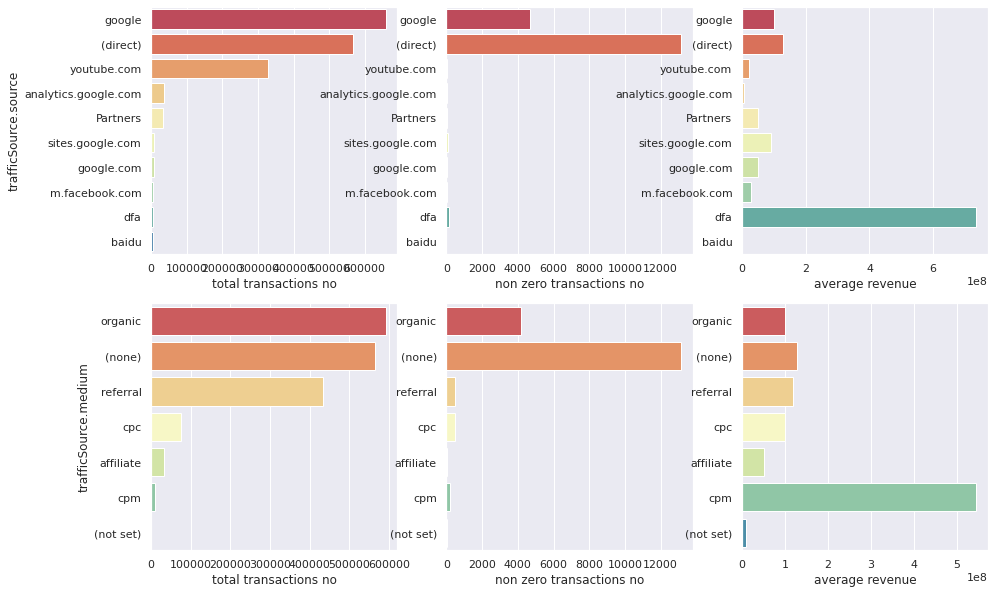

In [25]:
tf_source = df_train2.groupby('trafficSource.source')[['totals.transactionRevenue']].agg(['size', 'count', 'mean'])
tf_source.columns = ['total transactions no','non zero transactions no','average revenue']
tf_source = tf_source.sort_values(by='total transactions no', ascending=False)

tf_medium = df_train2.groupby('trafficSource.medium')[['totals.transactionRevenue']].agg(['size', 'count', 'mean'])
tf_medium.columns = ['total transactions no','non zero transactions no','average revenue']
tf_medium = tf_medium.sort_values(by='total transactions no', ascending=False)


fig , ax = plt.subplots(2 , 3 , figsize=(15,10))
plt.subplot(2,3,1)
sns.barplot(y=tf_source.index[0:10] , x=tf_source['total transactions no'].head(10), palette="Spectral")
plt.subplot(2,3,2)
sns.barplot(y=tf_source.index[0:10] , x=tf_source['non zero transactions no'].head(10), palette="Spectral").set(ylabel=None)
plt.subplot(2,3,3)
sns.barplot(y=tf_source.index[0:10] , x=tf_source['average revenue'].head(10), palette="Spectral").set(ylabel=None)

plt.subplot(2,3,4)
sns.barplot(y=tf_medium.index[0:10] , x=tf_medium['total transactions no'].head(10) ,palette="Spectral")
plt.subplot(2,3,5)
sns.barplot(y=tf_medium.index[0:10], x=tf_medium['non zero transactions no'].head(10), palette="Spectral").set(ylabel=None)
plt.subplot(2,3,6)
sns.barplot(y=tf_medium.index[0:10] , x=tf_medium['average revenue'].head(10), palette="Spectral").set(ylabel=None)

fig.show()

## Insight Found:

##### - Most transaction are done through desktop,then mobile in 2nd level then tablet in 3rd
##### - Customers using Machintosh OS make the most non zero revenue transaction numbers
##### - While talking about average revenue numbers, customers using windows makes the most revenue.
##### - Chrome & Safari browsers contribute in the most transactions number.
##### - Edge in addition to Chrome & Safari contributes in the most revenue.

##### - Americas continent has the most transactions number while Africa helps with the most revenue.
##### - Asia & Europe almost equal.
##### - USA participates with the most transactions while Japan with the most revenue.

##### - Most transactions made from people access through google, direct and youtube
##### - Most revenue made from perople accessed through dfa

## Check for constant columns

In [26]:
#df_train.select_dtypes(exclude='object').columns

remain_features= ['visitNumber', 'device.isMobile', 'totals.pageviews','socialEngagementType','channelGrouping'
                    ,'geoNetwork.metro','totals.visits', 'totals.hits','totals.newVisits', 
                    'trafficSource.campaign', 'customDimensions' ]

for col in remain_features:
    if len(df_train[col].unique()) == 1:
        print("{} is constant".format(col))


socialEngagementType is constant
totals.visits is constant


In [27]:
print(df_train['socialEngagementType'].unique())
print(df_train['totals.visits'].unique())

['Not Socially Engaged']
['1']


In [28]:
#drop columns that contain constant values.
df_train.drop('socialEngagementType',axis=1, inplace=True)
df_train.drop('totals.visits',axis=1, inplace=True)

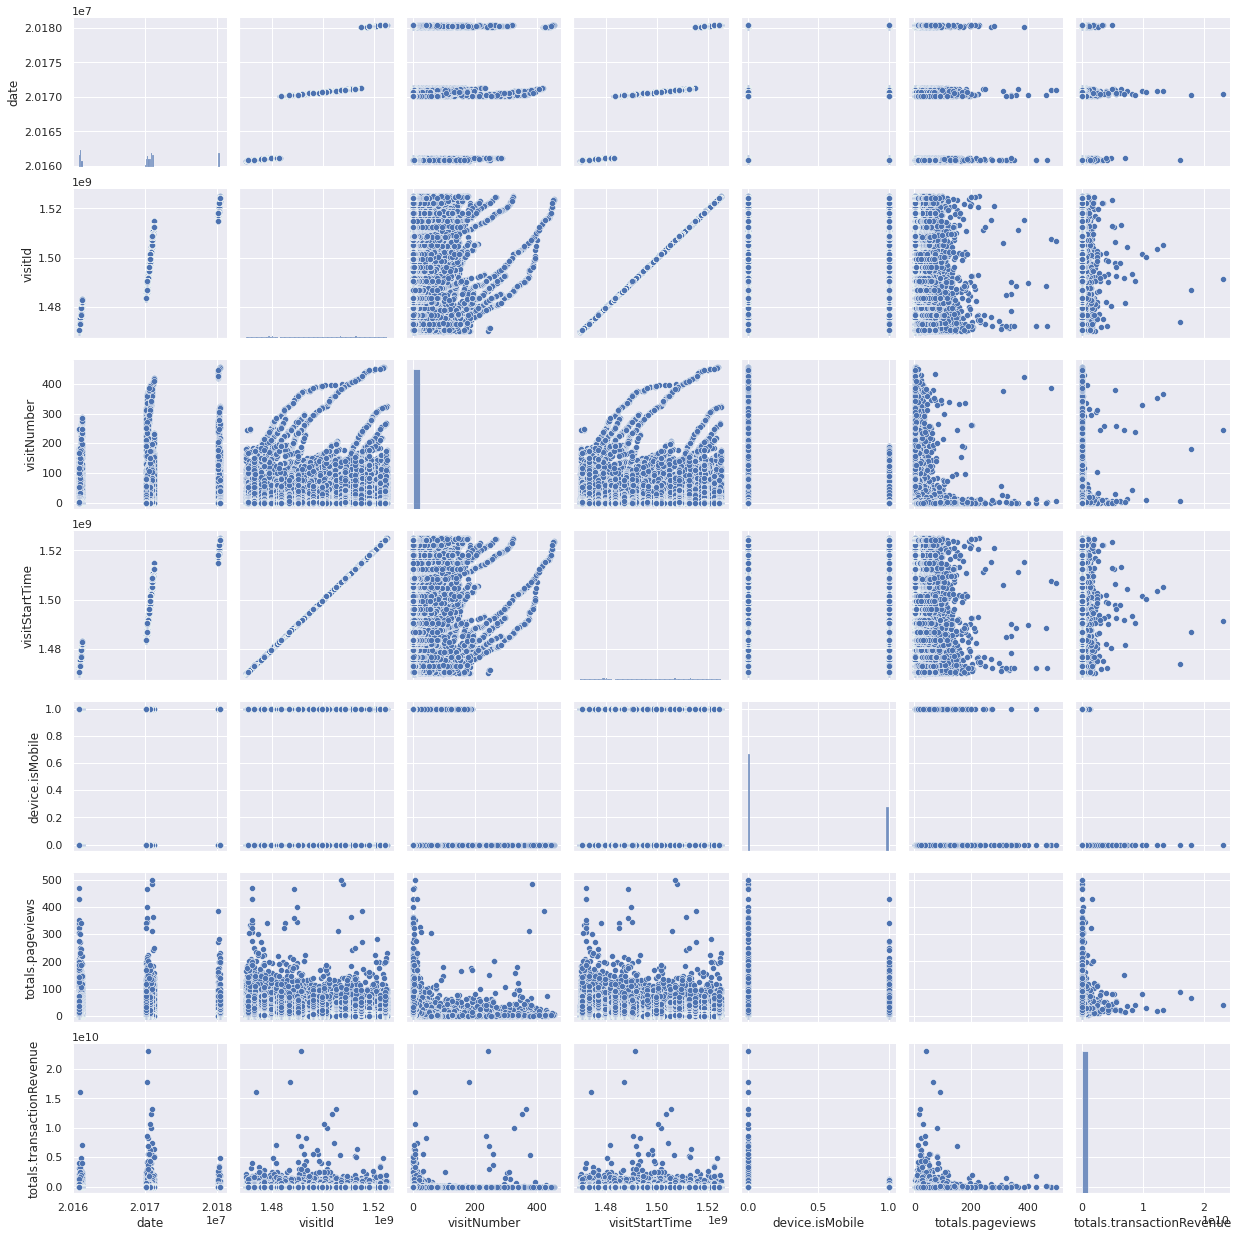

In [29]:
sns.pairplot(df_train, diag_kind="hist")


In [30]:
df_train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.deviceCategory',
       'device.isMobile', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.hits', 'totals.newVisits',
       'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.campaign', 'trafficSource.medium',
       'trafficSource.source', 'customDimensions'],
      dtype='object')

In [31]:
df_train['totals.hits']= df_train['totals.hits'].astype(int)

In [32]:
print(df_train['totals.newVisits'].value_counts())
print('-'*30)
print(df_train['visitNumber'].value_counts()[:10])
print('-'*30)
print(df_train['device.isMobile'].value_counts()[:10])

1    1307430
Name: totals.newVisits, dtype: int64
------------------------------
1     1307430
2      182542
3       70962
4       37886
5       23314
6       15702
7       11194
8        8338
9        6350
10       5018
Name: visitNumber, dtype: int64
------------------------------
0.0    1171670
1.0     536667
Name: device.isMobile, dtype: int64


In [33]:
print(df_train['totals.hits'].value_counts()[:10])
print('-'*30)
print(df_train['totals.pageviews'].value_counts()[:10])


1     864064
2     237499
3     134435
4      80875
5      63687
6      46598
7      38137
8      29717
9      24999
10     20306
Name: totals.hits, dtype: int64
------------------------------
1     876567
2     249794
3     142896
4      86666
5      64712
6      47721
7      37751
8      29586
9      24153
10     19228
Name: totals.pageviews, dtype: int64


## Transform & Dealing with dates

In [34]:
print(df_train['visitStartTime'][0])
df_train['visitStartTime'] = pd.to_datetime(df_train['visitStartTime'], unit='s')
print(df_train['visitStartTime'][0])
df_train['vst_dayofweek'] = df_train['visitStartTime'].dt.dayofweek
df_train['vst_hours'] = df_train['visitStartTime'].dt.hour
df_train['vst_dayofmonth'] = df_train['visitStartTime'].dt.day
print(df_train['vst_dayofweek'][0], df_train['vst_hours'][0], df_train['vst_dayofmonth'][0])
df_train.drop('visitStartTime', axis = 1, inplace = True)
    

1508198450
2017-10-17 00:00:50
1 0 17


In [35]:
format_str = '%Y%m%d'
df_train['formated_date'] = df_train['date'].apply(lambda x: datetime.strptime(str(x), format_str))
df_train['year'] = df_train['formated_date'].apply(lambda x:x.year)
df_train['month'] = df_train['formated_date'].apply(lambda x:x.month)
df_train['quarterMonth'] = df_train['formated_date'].apply(lambda x:x.day//8)
df_train['day'] = df_train['formated_date'].apply(lambda x:x.day)
df_train['weekday'] = df_train['formated_date'].apply(lambda x:x.weekday())

df_train.drop(['date','formated_date'], axis=1, inplace=True)

In [36]:
#drop ID columns as they're irrelevant features
irrelavant_features = ['fullVisitorId', 'visitId']
for col in irrelavant_features:
    df_train.drop(col, axis = 1, inplace = True)

In [37]:
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')


## Transform categorical features to numerical using Label Encoding method

In [38]:
%%time
le = LabelEncoder()
print('Categorical columns that will be converted:')
for col in df_train.columns:
    if df_train[col].dtype == 'O':
        print(col)
        #print(col, train[col].unique())
        df_train.loc[:, col] = le.fit_transform(df_train.loc[:, col])
    

Categorical columns that will be converted:
channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
totals.newVisits
trafficSource.campaign
trafficSource.medium
trafficSource.source
customDimensions
CPU times: user 26.4 s, sys: 1.7 s, total: 28.1 s
Wall time: 28.1 s


## Repeat same analysis on test data

In [39]:
print('No of columns in test set ',len(df_test.columns))
print('Columns in train and not in test are: ',set(df_train)-set(df_test))

null_percentage = pd.DataFrame()
for col in df_test.columns:
    if df_test[col].isnull().sum() > 0:
        null_percentage.loc[col,'NullPercentage'] = (df_test[col].isnull().sum())/len(df_test) * 100 
print(null_percentage)

#drop or fill

No of columns in test set  28
Columns in train and not in test are:  {'vst_hours', 'weekday', 'year', 'quarterMonth', 'vst_dayofweek', 'day', 'month', 'vst_dayofmonth'}
                           NullPercentage
totals.newVisits                28.766724
totals.pageviews                 0.025150
totals.transactionRevenue       98.856044


In [40]:
print(df_test['totals.pageviews'].isnull().sum())
print(df_test['totals.pageviews'].dtype)

print(df_test['totals.pageviews'] .mode())
print((df_test["totals.pageviews"]=='1').sum())

df_test['totals.pageviews'] = df_test['totals.pageviews'].fillna(1)

df_test['totals.pageviews'] = df_test['totals.pageviews'].astype(int)

101
object
0    1
dtype: object
183926


In [41]:
print(df_test['totals.newVisits'].isnull().sum())
print(df_test['totals.newVisits'].dtype)

print(df_test['totals.newVisits'] .mode())
print((df_test["totals.newVisits"]=='1').sum())
df_test['totals.pageviews'] = df_test['totals.pageviews'].fillna(1)

df_test['totals.pageviews'] = df_test['totals.pageviews'].astype(int)

115524
object
0    1
dtype: object
286065


In [42]:
df_test.drop('totals.transactionRevenue', axis=1, inplace=True)

In [43]:
for col in df_test.columns:
    if df_test.nunique == 1:
        print("{} is constant".format(col))
        df_test.drop(col, axis=1, inplace=True)

In [44]:
df_train['totals.hits']= df_train['totals.hits'].astype(int)

In [45]:
print(df_test['visitStartTime'][0])
df_test['visitStartTime'] = pd.to_datetime(df_test['visitStartTime'], unit='s')
print(df_test['visitStartTime'][0])
df_test['vst_dayofweek'] = df_test['visitStartTime'].dt.dayofweek
df_test['vst_hours'] = df_test['visitStartTime'].dt.hour
df_test['vst_dayofmonth'] = df_test['visitStartTime'].dt.day
print(df_test['vst_dayofweek'][0], df_test['vst_hours'][0], df_test['vst_dayofmonth'][0])
df_test.drop('visitStartTime', axis = 1, inplace = True)

1526099341
2018-05-12 04:29:01
5 4 12


In [46]:
format_str = '%Y%m%d'
df_test['formated_date'] = df_test['date'].apply(lambda x: datetime.strptime(str(x), format_str))
df_test['year'] = df_test['formated_date'].apply(lambda x:x.year)
df_test['month'] = df_test['formated_date'].apply(lambda x:x.month)
df_test['quarterMonth'] = df_test['formated_date'].apply(lambda x:x.day//8)
df_test['day'] = df_test['formated_date'].apply(lambda x:x.day)
df_test['weekday'] = df_test['formated_date'].apply(lambda x:x.weekday())

df_test.drop(['date','formated_date'], axis=1, inplace=True)

In [47]:
irrelavant_features = ['fullVisitorId', 'visitId', 'socialEngagementType' , 'totals.visits']
for col in irrelavant_features:
    df_test.drop(col, axis = 1, inplace = True)

In [48]:
le = LabelEncoder()
print('Categorical columns that will be converted:')
for col in df_test.columns:
    if df_test[col].dtype == 'O':
        print(col)
        #print(col, train[col].unique())
        df_test.loc[:, col] = le.fit_transform(df_test.loc[:, col])

Categorical columns that will be converted:
channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
totals.hits
totals.newVisits
trafficSource.adContent
trafficSource.campaign
trafficSource.medium
trafficSource.source
customDimensions


In [49]:
print('Columns in train and not in test are: ',set(df_train)-set(df_test))

Columns in train and not in test are:  {'totals.transactionRevenue'}


We made sure that there's no extra columns in train data than test data except our target 'totals.transactionReveue'

## Modelling

In [50]:
model = lgb.LGBMRegressor(
        num_leaves = 31,  #(default = 31) – Maximum tree leaves for base learners.
        learning_rate = 0.03, #(default = 0.1) – Boosting learning rate. You can use callbacks parameter of fit method to shrink/adapt learning rate in training using 
                              #reset_parameter callback. Note, that this will ignore the learning_rate argument in training.
        n_estimators = 1000, #(default = 100) – Number of boosted trees to fit.
        subsample = .9, #(default = 1.) – Subsample ratio of the training instance.
        colsample_bytree = .9, #(default = 1.) – Subsample ratio of columns when constructing each tree
        random_state = 34
)

##### I'll divide data to achieve almost 60% train - 20% validation and 20% test

In [51]:
print(len(df_train) , len(df_test))
print(len(df_test) / len(df_train) * 100)

1708337 401589
23.507598325154813


In [52]:
print(len(df_train) - len(df_test) )

1306748


In [53]:
y = df_train['totals.transactionRevenue']


In [54]:
y

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1708332    0.0
1708333    0.0
1708334    0.0
1708335    0.0
1708336    0.0
Name: totals.transactionRevenue, Length: 1708337, dtype: float64

In [55]:
df_train.drop('totals.transactionRevenue' , axis=1, inplace=True)


In [56]:
X = df_train
X.shape

(1708337, 28)

In [57]:
X_train = X[:1306748]
X_val = X[1306749:]

y_train = y[:1306748]
y_val = y[1306749:]

print(X_train.shape , y_train.shape)
print(X_val.shape , y_val.shape)

(1306748, 28) (1306748,)
(401588, 28) (401588,)


In [58]:
 model.fit(
        X_train, np.log1p(y_train),
        eval_set = [(X_val, np.log1p(y_val))],
        early_stopping_rounds = 100,
        verbose = 100,
        eval_metric = 'rmse'
    )

[100]	valid_0's rmse: 1.53681	valid_0's l2: 2.3618
[200]	valid_0's rmse: 1.524	valid_0's l2: 2.32259
[300]	valid_0's rmse: 1.51944	valid_0's l2: 2.30871
[400]	valid_0's rmse: 1.51595	valid_0's l2: 2.29811
[500]	valid_0's rmse: 1.51462	valid_0's l2: 2.29406
[600]	valid_0's rmse: 1.51379	valid_0's l2: 2.29155
[700]	valid_0's rmse: 1.51273	valid_0's l2: 2.28836
[800]	valid_0's rmse: 1.51258	valid_0's l2: 2.2879


LGBMRegressor(colsample_bytree=0.9, learning_rate=0.03, n_estimators=1000,
              random_state=34, subsample=0.9)

### Check features Importance

In [59]:
features_importance = pd.DataFrame()
features_importance['feature'] = X_train.columns
features_importance['importance'] = model.booster_.feature_importance(importance_type = 'gain')
features_importance.sort_values(by = 'importance', ascending = False)[:10]

,feature,importance
15,totals.pageviews,1.399220e+07
8,geoNetwork.country,4.089749e+06
1,visitNumber,2.013000e+06
13,totals.hits,1.984754e+06
24,month,9.647741e+05
21,vst_hours,6.472161e+05
17,trafficSource.medium,6.203753e+05
0,channelGrouping,6.052517e+05
22,vst_dayofmonth,4.847233e+05
3,device.deviceCategory,4.439118e+05


In [60]:
predictions = model.predict(X_val, num_iteration = model.best_iteration_)
predictions[predictions < 0] = 0

In [61]:
mean_squared_error(np.log1p(y_val), predictions)

2.286075432199832

In [62]:
test_predictions = pd.DataFrame()
test_predictions = model.predict(df_test[X_train.columns], num_iteration = model.best_iteration_)
test_predictions[test_predictions < 0] = 0
test_predictions

array([1.54738592, 1.5472054 , 2.22188123, ..., 0.        , 0.        ,
       0.05101585])

In [63]:
test_predictions = pd.DataFrame(test_predictions)
test_predictions.head()

,0
0,1.547386
1,1.547205
2,2.221881
3,0.000000
4,0.000000


In [64]:
test_Ids = pd.read_csv('../input/ga-customer-revenue-prediction/test_v2.csv', usecols=['fullVisitorId'])
test_Ids['fullVisitorId']= test_Ids['fullVisitorId'].astype(str)
test_Ids.dtypes

fullVisitorId    object
dtype: object

In [65]:
submission = pd.concat([test_Ids , test_predictions] , axis=1)
submission.columns = ['fullVisitorId','PredictedLogRevenue']
submission.head(10)

,fullVisitorId,PredictedLogRevenue
0,7460955084541987166,1.547386
1,460252456180441002,1.547205
2,3461808543879602873,2.221881
3,975129477712150630,0.000000
4,8381672768065729990,0.000000
5,2866297766347322467,0.000000
6,2235365487897339889,0.000000
7,1303090465617023038,0.000000
8,459669224143241747,0.000000
9,589440789980446309,0.000000


In [66]:
submission = submission.groupby('fullVisitorId').sum().reset_index()
submission.head(10)

,fullVisitorId,PredictedLogRevenue
0,0000039738481224681,0.001835
1,0000196310838896290,0.076768
2,0000268499301061358,0.001017
3,0000450284137157873,0.000000
4,0000507436339585432,0.000000
5,0000528281082051132,0.001552
6,0000545498494146189,0.183888
7,0000641682591390335,0.000888
8,0000779540350222621,0.000000
9,0000900085223565423,0.001437


In [67]:
submission.to_csv('submit.csv', index=False)

### Credits of 
#####  -Memory reduce idea & method to "Customer Revenue Prediction V2 : playground notebook"
#####  -Date transorm and tuning of some model parameters to: "Basics of Google Analytics notebook"


### Finally you can read more about Lightgbm from here:
[https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html](http://)
[https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/](http://)